In [1]:
import sys
import clipboard
sys.path.append('C:\\Users\\Administrator\\source\\repos\\numpy_test\\x64\\Release')
import numpy_test
import importlib

In [2]:
import PIL, numpy as np, cv2

In [3]:
from PIL.ImageGrab import grab as screenshot

In [4]:
ss = screenshot((500, 500, 800, 600))

In [5]:
numpy_test.test("test\n")

In [6]:
np.asarray(ss).dtype

dtype('uint8')

In [7]:
numpy_test.mask_grayscale(np.array(ss))

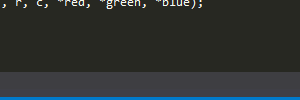

In [8]:
ss

In [9]:
np.array(ss).shape

(100, 300, 3)